In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
df = pd.read_csv('../data/day10_all_steps.csv')
df.head()


,step,cell_type,x,y,dx,dy,clone_id,vessel_neighbourhood,status
0,0,40,234.0430,245.3894,0.0,0.0,-1,1,0
1,0,40,402.7701,470.5997,0.0,0.0,-1,0,0
2,0,40,379.0508,496.0000,0.0,0.0,-1,0,0
3,0,40,375.1551,255.7135,0.0,0.0,-1,1,0
4,0,40,211.6660,419.7212,0.0,0.0,-1,0,0


In [47]:
counts = df.groupby('step')['cell_type'].value_counts().reset_index()
counts

,step,cell_type,count
0,0,18,1256
1,0,17,646
2,0,26,397
3,0,16,318
4,0,40,252
...,...,...,...
55847,1439,5,2
55848,1439,0,1
55849,1439,2,1
55850,1439,7,1


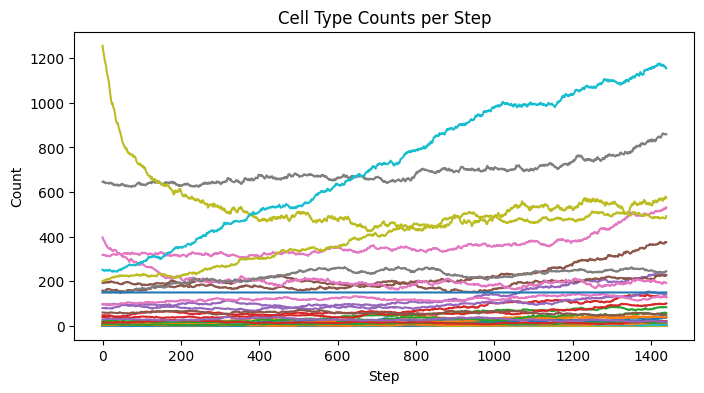

In [48]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=counts, x='step', y='count', hue='cell_type', legend=False, palette='tab10')
plt.title('Cell Type Counts per Step')
plt.xlabel('Step')
plt.ylabel('Count')
plt.show()

In [41]:
counts[counts.step == 1439]

,step,cell_type,count
55084,1439,18,2732
55085,1439,40,2623
55086,1439,17,2052
55087,1439,16,1090
55088,1439,39,860
55089,1439,26,788
55090,1439,25,634
55091,1439,15,525
55092,1439,38,515
55093,1439,24,427
